In [28]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import datetime

In [29]:
charging = pd.read_csv("../charging_sessions.csv", encoding = "ISO-8859-1")

In [30]:
charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])

charging['connectionTime'] = charging['connectionTime'].dt.tz_localize(None)
charging['disconnectTime'] = charging['disconnectTime'].dt.tz_localize(None)

charging = charging[~charging['id'].duplicated(keep=False)]

site_a = charging[charging["siteID"] == 1]
site_b = charging[charging["siteID"] == 2]



In [31]:
unique_spaces_a = site_a["stationID"].nunique()
unique_spaces_b = site_b["stationID"].nunique()

print(unique_spaces_a)
print(unique_spaces_b)

52
55


In [32]:
def create_utilization(df) -> pd.DataFrame:
    result = []

    # Filter unique days to include only those with at least one connection or disconnection
    relevant_days = pd.date_range(
        start=df['connectionTime'].dt.date.min(), 
        end=df['disconnectTime'].dt.date.max()
    )
    relevant_days = [
        day for day in relevant_days 
        if ((df['connectionTime'].dt.date <= day) & (df['disconnectTime'].dt.date >= day)).any()
    ]

    # Iterate through each relevant day
    for day in relevant_days:
        # Generate hourly time slots for the day
        time_slots = pd.date_range(start=day, periods=24, freq='H')
        for time in time_slots:
            # Count the number of cars parked during this hour
            utilization = np.sum((df['connectionTime'] <= time) & (df['disconnectTime'] > time))
            result.append({'time': time.hour, 'utilization': utilization})

    # Convert the result list to a dataframe
    return pd.DataFrame(result)
utilization_a = create_utilization(site_a)
utilization_b = create_utilization(site_b)



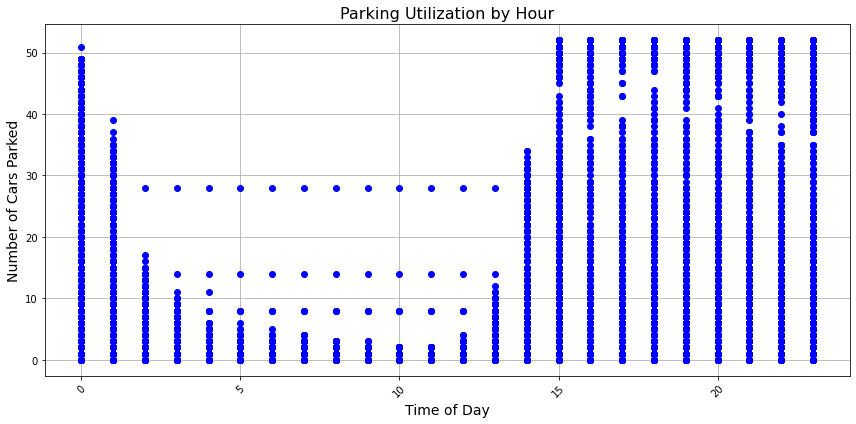

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(utilization_a['time'], utilization_a['utilization'], marker='o', linestyle='', color='b')

# Formatting the plot
plt.title('Parking Utilization by Hour', fontsize=16)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Number of Cars Parked', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

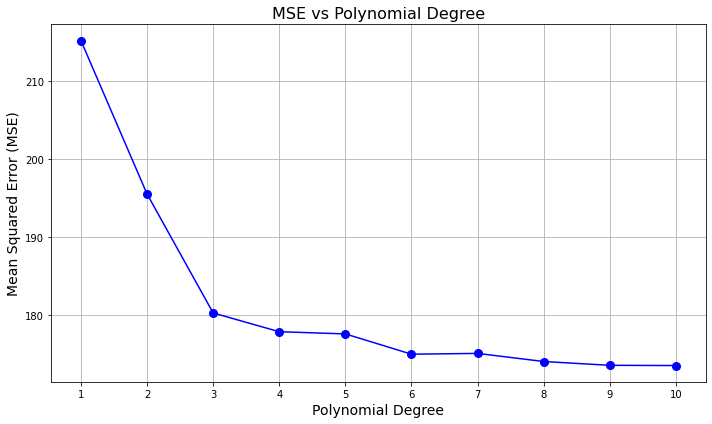

In [34]:
x_a = utilization_a["time"].values.reshape(-1, 1)
y_a = utilization_a["utilization"]

mse_values = []

# Loop through polynomial degrees from 1 to 10
for poly_degree in range(1, 11):
    # Transform the feature to include polynomial terms
    poly = PolynomialFeatures(degree=poly_degree)
    x_a_poly = poly.fit_transform(x_a)  # Transform the data to include polynomial features

    # Split the data into training and testing sets
    x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a_poly, y_a, test_size=0.5, random_state=42)

    # Create and fit the Linear Regression model
    model = LinearRegression()
    model.fit(x_a_train, y_a_train)

    # Make predictions
    y_a_pred = model.predict(x_a_test)

    # Calculate the MSE for this degree
    mse = mean_squared_error(y_a_test, y_a_pred)
    mse_values.append(mse)

# Plot MSE values for each degree of polynomial
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), mse_values, marker='o', color='b', linestyle='-', markersize=8)
plt.title('MSE vs Polynomial Degree', fontsize=16)
plt.xlabel('Polynomial Degree', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.grid(True)
plt.xticks(range(1, 11))  # To ensure all degrees are labeled on the x-axis
plt.tight_layout()
plt.show()

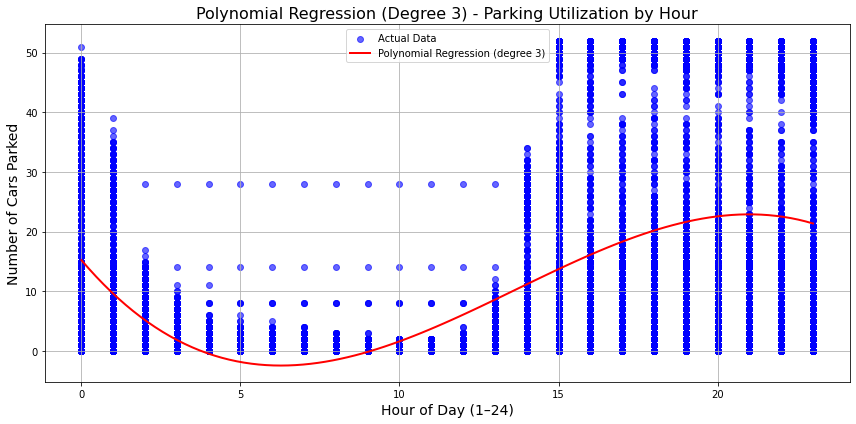

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Transform the feature to include polynomial terms (e.g., quadratic, cubic, etc.)
poly_degree = 3  # Degree of the polynomial (can be adjusted)
poly = PolynomialFeatures(degree=poly_degree)
x_a_poly = poly.fit_transform(x_a)  # Transform the data to include polynomial features

x_a_train, x_a_test, y_a_train, y_a_test = train_test_split(x_a_poly, y_a, test_size=0.3, random_state=42)

# Create and fit the Linear Regression model
model = LinearRegression()
model.fit(x_a_train, y_a_train)

# Make predictions
y_a_pred = model.predict(x_a_test)

mse = mean_squared_error(y_a_test, y_a_pred)

plt.figure(figsize=(12, 6))
plt.scatter(x_a, y_a, color='blue', label='Actual Data', alpha=0.6)  # Plot the actual data

# Plot the Polynomial Regression predictions
X_grid = np.linspace(min(x_a), max(x_a), 100).reshape(-1, 1)  # Create a smooth grid for the x-axis
y_grid = model.predict(poly.transform(X_grid))  # Predict using the polynomial features

plt.plot(X_grid, y_grid, color='red', label=f'Polynomial Regression (degree {poly_degree})', linewidth=2)  # Plot the polynomial predictions

plt.title(f'Polynomial Regression (Degree {poly_degree}) - Parking Utilization by Hour', fontsize=16)
plt.xlabel('Hour of Day (1–24)', fontsize=14)
plt.ylabel('Number of Cars Parked', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Site B

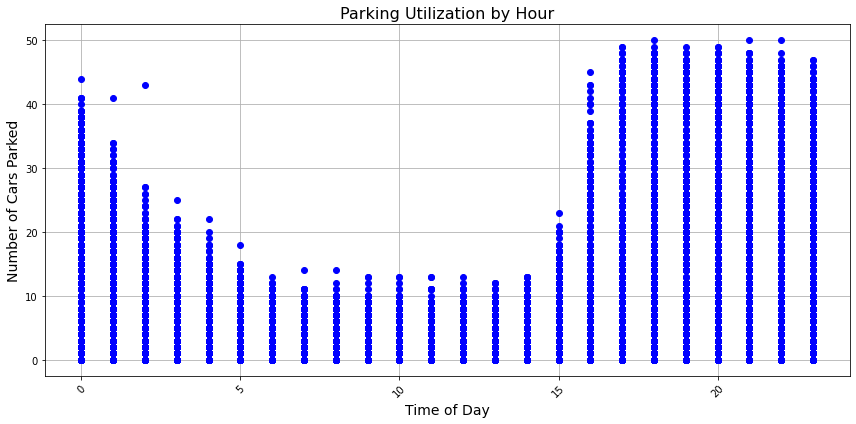

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(utilization_b['time'], utilization_b['utilization'], marker='o', linestyle='', color='b')

# Formatting the plot
plt.title('Parking Utilization by Hour', fontsize=16)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Number of Cars Parked', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

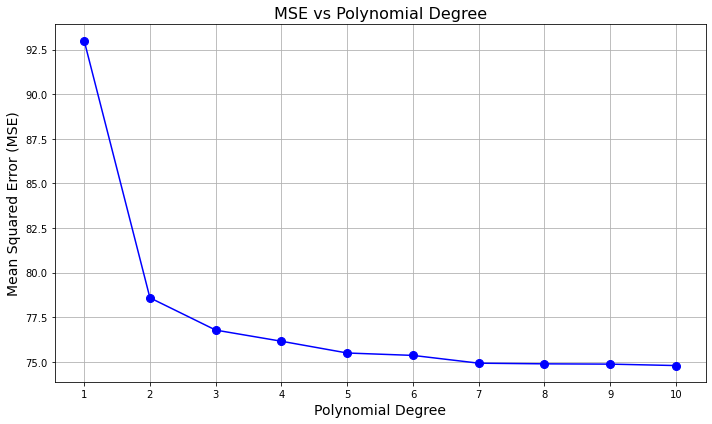

In [37]:
x_b = utilization_b["time"].values.reshape(-1, 1)
y_b = utilization_b["utilization"]

mse_values = []

# Loop through polynomial degrees from 1 to 10
for poly_degree in range(1, 11):
    # Transform the feature to include polynomial terms
    poly = PolynomialFeatures(degree=poly_degree)
    x_b_poly = poly.fit_transform(x_b)  # Transform the data to include polynomial features

    # Split the data into training and testing sets
    x_b_train, x_b_test, y_b_train, y_b_test = train_test_split(x_b_poly, y_b, test_size=0.5, random_state=42)

    # Create and fit the Linear Regression model
    model = LinearRegression()
    model.fit(x_b_train, y_b_train)

    # Make predictions
    y_b_pred = model.predict(x_b_test)

    # Calculate the MSE for this degree
    mse = mean_squared_error(y_b_test, y_b_pred)
    mse_values.append(mse)

# Plot MSE values for each degree of polynomial
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), mse_values, marker='o', color='b', linestyle='-', markersize=8)
plt.title('MSE vs Polynomial Degree', fontsize=16)
plt.xlabel('Polynomial Degree', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.grid(True)
plt.xticks(range(1, 11))  # To ensure all degrees are labeled on the x-axis
plt.tight_layout()
plt.show()

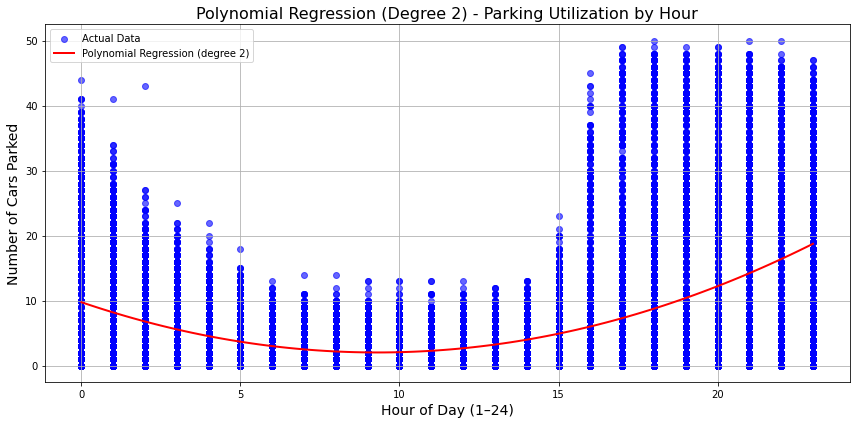

In [38]:
# Transform the feature to include polynomial terms (e.g., quadratic, cubic, etc.)
poly_degree = 2  # Degree of the polynomial (can be adjusted)
poly = PolynomialFeatures(degree=poly_degree)
x_b_poly = poly.fit_transform(x_b)  # Transform the data to include polynomial features

x_b_train, x_b_test, y_b_train, y_b_test = train_test_split(x_b_poly, y_b, test_size=0.3, random_state=42)

# Create and fit the Linear Regression model
model = LinearRegression()
model.fit(x_b_train, y_b_train)

# Make predictions
y_b_pred = model.predict(x_b_test)

mse = mean_squared_error(y_b_test, y_b_pred)

plt.figure(figsize=(12, 6))
plt.scatter(x_b, y_b, color='blue', label='Actual Data', alpha=0.6)  # Plot the actual data

# Plot the Polynomial Regression predictions
X_grid = np.linspace(min(x_b), max(x_b), 100).reshape(-1, 1)  # Create a smooth grid for the x-axis
y_grid = model.predict(poly.transform(X_grid))  # Predict using the polynomial features

plt.plot(X_grid, y_grid, color='red', label=f'Polynomial Regression (degree {poly_degree})', linewidth=2)  # Plot the polynomial predictions

plt.title(f'Polynomial Regression (Degree {poly_degree}) - Parking Utilization by Hour', fontsize=16)
plt.xlabel('Hour of Day (1–24)', fontsize=14)
plt.ylabel('Number of Cars Parked', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()